# VISUALIZE OUTPUT FROM REGISTRATION

- change `DATA_PTH` to point to your main processing output folder
- change `REG_DIR` to point to the directory where registration output is stored. tifs should be stored there as `0000.tif`

`conda activate imgpro`

In [49]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

fixed = '0166' # 20251028 worm001
# fixed = '0002' # 20251121 worm002

mov = '0050'

chan = 1 # 0,gfp 1,rfp

DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'
# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# REG_DIR = 'registered'
REG_DIR = 'registered_gfp+1'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-4_dynamic-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-15_dynamic-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-11_dynamic-100'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10_gfp+1'

FIXED_PTH = os.path.join(DATA_PTH,'warped',f'{fixed}.tif')
REG_PTH = os.path.join(DATA_PTH,REG_DIR,f'{mov}.tif')
WARP_PTH = os.path.join(DATA_PTH,'warped',f'{mov}.tif')

if 'wholistic' in REG_DIR:
    zoom = 1 
else:
    zoom = 1 #1/3 # 3
# fixed = ndi.zoom(tifffile.imread(FIXED_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)
# move = tifffile.imread(REG_PTH)[:,chan,:,:] # just the red channel (ZHW)
# warped = ndi.zoom(tifffile.imread(WARP_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)

fixed = tifffile.imread(FIXED_PTH)[:,chan,:,:] # just the red channel (ZHW)
reg = ndi.zoom(tifffile.imread(REG_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)
warped = tifffile.imread(WARP_PTH)[:,chan,:,:] # just the red channel (ZHW)

if 'gfp+1' in REG_DIR:
    reg = np.concatenate((reg, np.zeros((1,200,500))), axis=0)

reg_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg[np.newaxis,:,:,:]), axis=0) # CZHW

warp_stack = np.concatenate((fixed[np.newaxis,:,:,:],warped[np.newaxis,:,:,:]), axis=0)

CREATE PANEL

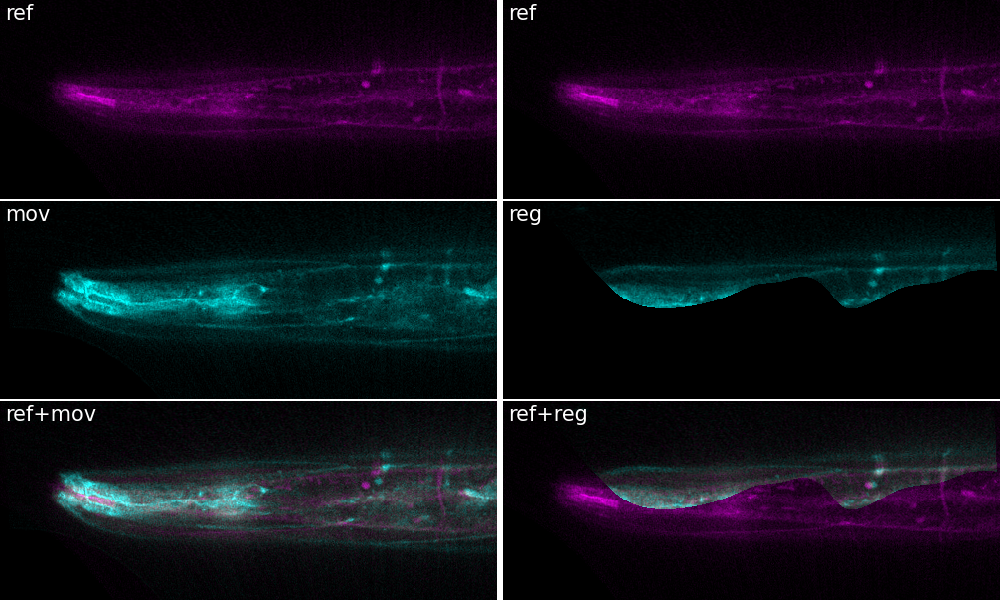

In [53]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
# mx = 100
fs = 5

cmap_ref = 'magenta'
cmap_mov_reg = 'cyan'

anim1 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim2 = Microanim(
    data=warped[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='mov')
anim3 = Microanim(
    data=warp_stack, cmaps=[cmap_ref, cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+mov')


anim4 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim5 = Microanim(
    data=reg[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='reg')
anim6 = Microanim(
    data=reg_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+reg')

plt.close('all')

animpanel = Microanimpanel(rows=3, cols=2,)
animpanel.add_element(pos=[0,0], microanim=anim1)
animpanel.add_element(pos=[1,0], microanim=anim2)
animpanel.add_element(pos=[2,0], microanim=anim3)

animpanel.add_element(pos=[0,1], microanim=anim4)
animpanel.add_element(pos=[1,1], microanim=anim5)
animpanel.add_element(pos=[2,1], microanim=anim6)

animpanel.ui



SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
OUT_FN = ''

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

# COMPARE ELASTIX TO WHOLISTIC

- change `DATA_PTH` to point to your main processing output folder
- change `registered_elx_dir` and `registered_who_dir`

`conda activate imgpro`

In [ ]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

fixed = '0166' # 20251028 worm001
# fixed = '0002' # 20251121 worm002
mov = '0090'
chan = 1 # 0,gfp 1,rfp

DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

registered_elx_dir = 'registered'
registered_who_dir = 'wholistic_registered_smooth-0.02_patch-9_dynamic'
# registered_who_dir = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'

FIXED_PTH = os.path.join(DATA_PTH,'warped',f'{fixed}.tif')
REG_ELX_PTH = os.path.join(DATA_PTH,registered_elx_dir,f'{mov}.tif')
REG_WHO_PTH = os.path.join(DATA_PTH,registered_who_dir,f'{mov}.tif')
WARP_PTH = os.path.join(DATA_PTH,'warped',f'{mov}.tif')

fixed = tifffile.imread(FIXED_PTH)[:,chan,:,:] # just the red channel (ZHW)
reg_elx = ndi.zoom(tifffile.imread(REG_ELX_PTH)[:,chan,:,:], zoom=(1/3,1,1))
reg_who = tifffile.imread(REG_WHO_PTH)[:,chan,:,:]
warped = tifffile.imread(WARP_PTH)[:,chan,:,:] # just the red channel (ZHW)

warp_stack = np.concatenate((fixed[np.newaxis,:,:,:],warped[np.newaxis,:,:,:]), axis=0)
elx_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg_elx[np.newaxis,:,:,:]), axis=0) # CZHW
who_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg_who[np.newaxis,:,:,:]), axis=0)

CREATE PANEL

In [ ]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
# mx = 100
fs = 5

cmap_ref = 'magenta'
cmap_mov_reg = 'cyan'

anim1 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim2 = Microanim(
    data=warped[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='mov')
anim3 = Microanim(
    data=warp_stack, cmaps=[cmap_ref, cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+mov')

anim4 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim5 = Microanim(
    data=reg_elx[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='elx')
anim6 = Microanim(
    data=elx_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+elx')

anim7 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim8 = Microanim(
    data=reg_who[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='who')
anim9 = Microanim(
    data=who_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+who')

plt.close('all')

animpanel = Microanimpanel(rows=3, cols=3,)
animpanel.add_element(pos=[0,0], microanim=anim1)
animpanel.add_element(pos=[1,0], microanim=anim2)
animpanel.add_element(pos=[2,0], microanim=anim3)
animpanel.add_element(pos=[0,1], microanim=anim4)
animpanel.add_element(pos=[1,1], microanim=anim5)
animpanel.add_element(pos=[2,1], microanim=anim6)
animpanel.add_element(pos=[0,2], microanim=anim7)
animpanel.add_element(pos=[1,2], microanim=anim8)
animpanel.add_element(pos=[2,2], microanim=anim9)

animpanel.ui


SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
OUT_FN = ''

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

# CREATE MOVIE OF RECORDING

## MIP

LOAD DATA

In [54]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

# REG_DIR =  'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-15_dynamic-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-11_dynamic-100'
REG_DIR = 'wholistic_registered_smooth-0.05_patch-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10_gfp+1'

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif')) # each tif stack is of size ZCHW

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

mip = np.zeros((2,T,H,W)) # CTHW
for i in tqdm(range(T)):
    mip[:,i,:,:] = np.max(tifffile.imread(reg_contents[i]), axis=0) #CTHW
    # mip[:,i,:,:] = tifffile.imread(reg_contents[i])[13,:,:,:

100%|██████████| 232/232 [00:13<00:00, 17.28it/s]


SAVE MOVIE

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 600) to (1504, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


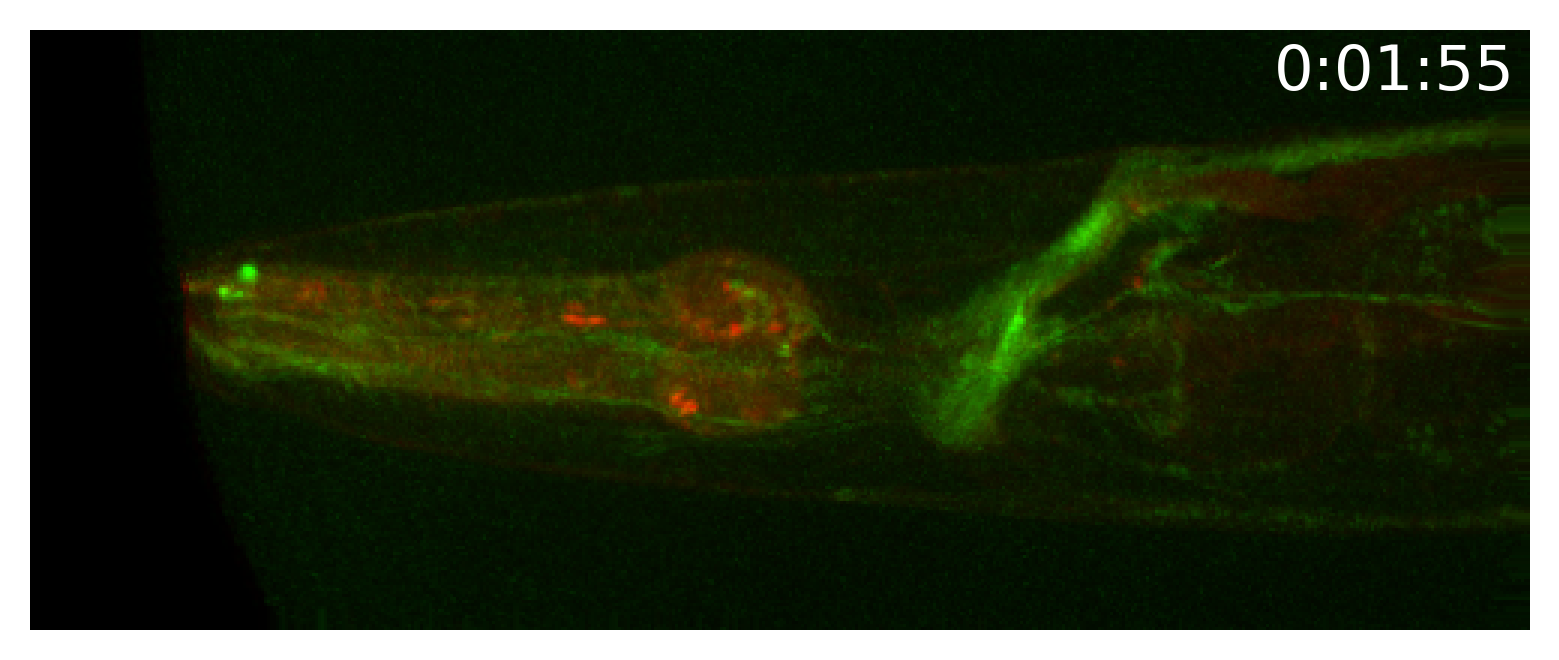

In [55]:
OUT_DIR = 'reg_vids'

# OUT_FN = 'mip-reg-elx.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.02_patch-9-dynamic-40.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.1_patch-5-dynamic-20.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.05_patch-15-dynamic-10.mp4'
OUT_FN = 'mip-reg-who_smooth-0.05_patch-10.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.05_patch-10_gfp+1.mp4'

%matplotlib inline
anim = Microanim(
    mip, cmaps=['green','red'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,256],[0,2000]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

## A SINGLE Z-SLICE

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# REG_DIR =  'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'

z_ix = 13

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif')) # each tif stack is of size ZCHW

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

zs = np.zeros((2,T,H,W)) # CTHW
for i in tqdm(range(T)):
    zs[:,i,:,:] = tifffile.imread(reg_contents[i])[z_ix,:,:,:]

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'

# OUT_FN = f'z{z_ix}_reg-elx.mp4'
# OUT_FN = f'z{z_ix}_reg-who_smooth-0.02_patch-9-dynamic-40.mp4'
OUT_FN = f'z{z_ix}_reg-who_smooth-0.1_patch-5-dynamic-20.mp4'

%matplotlib inline
anim = Microanim(
    mip, cmaps=['green','red'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,256],[0,2000]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

# CREATE MOVIE OF A PANEL OF ALL FRAMES OVER RECORDING 

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage
from microfilm.microanim import Microanimpanel


DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

REG_DIR =  'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

if 'wholistic' in REG_DIR:
    zstart = 4
    zend = 20
else:
    zstart = 12
    zend = 60
numZ = 20
nFrames = 400
nFrames = np.min((nFrames,T))


z2use = np.linspace(zstart,zend,numZ,dtype=int) # for elastix
im = np.zeros((len(z2use),2,nFrames,H,W))
for i in tqdm(range(nFrames)): #tqdm(range(len(reg_contents))):
    im[:,:,i,:,:] = tifffile.imread(reg_contents[i])[z2use,:,:,:]


SAVE MOVIE

In [ ]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
fs = 1
dpi = 300
g_lm = [0, 225]
r_lm = [0, 1500]

nrows = 4
ncols = 5
num_z = im.shape[0]

anim = []

for i in range(num_z):
    anim.append(Microanim(
        data=im[i,:,:,:,:], cmaps=['pure_green', 'pure_red'], flip_map=False, fig_scaling=fs, dpi=dpi,
        rescale_type='limits', limits=[g_lm, r_lm], label_text=f'z{z2use[i]}'))
anim[0].add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')


plt.close('all')

animpanel = Microanimpanel(rows=nrows, cols=ncols)
k = 0 # Counter for the anim list
for r in range(nrows):
    for c in range(ncols):
        # Stop when you run out of Microanim objects (k reaches 39)
        if k < num_z:
            # Calculate the position and add the element
            animpanel.add_element(pos=[r, c], microanim=anim[k])
            k += 1
        else:
            # Break out of the inner loop if all animes have been added
            break
    # Break out of the outer loop if all animes have been added
    if k >= num_z:
        break


animpanel.ui

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
# OUT_FN = 'zall_reg-elx.mp4'
# OUT_FN = 'zall_reg-who_smooth-0.02_patch-9_dynamic-40.mp4'
OUT_FN = 'zall_reg-who_smooth-0.1_patch-5_dynamic-20.mp4'

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=4)

# CREATE MOVIE OF REGISTERED RFP AND FIXED RFP OVER RECORDING

## MIP

LOAD DATA

In [56]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

fixed = '0166' # 20251028 worm001
# fixed = '0002' # 20251121 worm002

# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

FIXED_PTH = os.path.join(DATA_PTH,REG_DIR,f'{fixed}.tif')

# REG_DIR = 'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-15_dynamic-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-11_dynamic-100'
REG_DIR = 'wholistic_registered_smooth-0.05_patch-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10_gfp+1'

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

fixed = np.tile(np.max(tifffile.imread(FIXED_PTH), axis=0)[1], [T,1,1])
fixed = fixed[np.newaxis,:,:,:]

mip = np.zeros((1,T,H,W))
for i in tqdm(range(T)):
    mip[:,i,:,:] = np.max(tifffile.imread(reg_contents[i]), axis=0)[1] #CTHW


img = np.concat(((fixed,mip)),axis=0)



100%|██████████| 232/232 [00:13<00:00, 16.63it/s]


SAVE MOVIE

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 600) to (1504, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


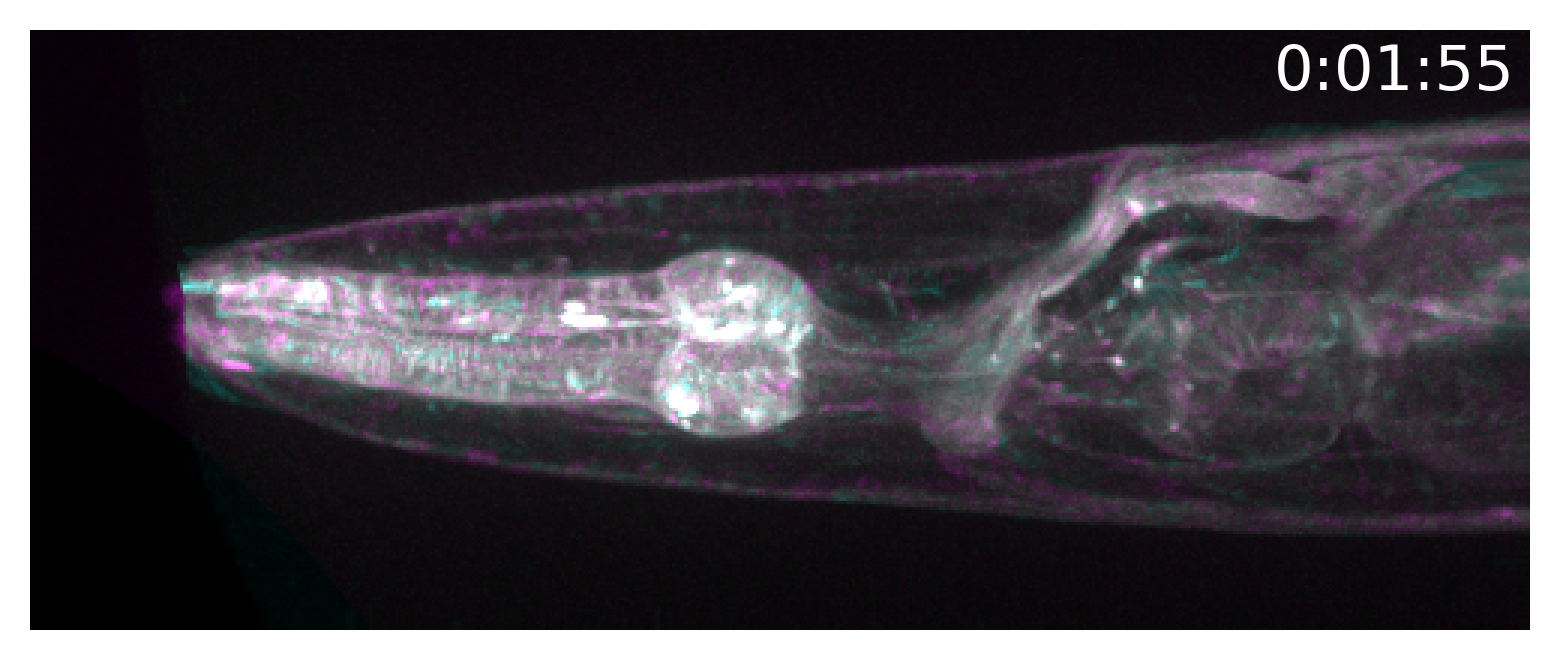

In [57]:
OUT_DIR = 'reg_vids'

# OUT_FN = 'zmip_ref+reg_reg-elx.mp4'
# OUT_FN = 'mip_ref+reg_reg-who_smooth-0.02_patch-9_dynamic-40.mp4'
# OUT_FN = 'mip_ref+reg_reg-who_smooth-0.1_patch-5_dynamic-20.mp4'
# OUT_FN = 'mip_ref+reg_reg-who_smooth-0.05_patch-15_dynamic-10.mp4'
# OUT_FN = 'mip_ref+reg_reg-who_smooth-0.05_patch-11_dynamic-100.mp4'
OUT_FN = 'mip_ref+reg_reg-who_smooth-0.05_patch-10.mp4'
# OUT_FN = 'mip_ref+reg_reg-who_smooth-0.05_patch-10_gfp+1.mp4'

%matplotlib inline
anim = Microanim(
    img, cmaps=['pure_magenta','pure_cyan'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,750],[0,750]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=5, fps=6)

## A SINGLE Z-SLICE

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

fixed = '0166' # 20251028 worm001
# fixed = '0002' # 20251121 worm002

DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
FIXED_PTH = os.path.join(DATA_PTH,REG_DIR,f'{fixed}.tif')

# REG_DIR = 'registered'
REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'

z_ix = 13

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

fixed = np.tile(tifffile.imread(FIXED_PTH)[z_ix,1,:,:], [T,1,1])
fixed = fixed[np.newaxis,:,:,:]

zs = np.zeros((1,T,H,W))
for i in tqdm(range(T)):
    zs[:,i,:,:] = tifffile.imread(reg_contents[i])[z_ix,1,:,:] #CTHW


img = np.concat(((fixed,zs)),axis=0)

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'

# OUT_FN = f'z{z_ix}_ref+reg_reg-elx.mp4'
OUT_FN = f'z{z_ix}_ref+reg_reg-who_smooth-0.02_patch-9_dynamic-40.mp4'
# OUT_FN = f'z{z_ix}_ref+reg_reg-who_smooth-0.1_patch-5_dynamic-20.mp4'


%matplotlib inline
anim = Microanim(
    img, cmaps=['pure_magenta','pure_cyan'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,750],[0,750]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=5, fps=6)